# Test Network on Danish Fungi 2020 Dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch

from src.core import models, training, data, metrics
from src.utils import nb_setup, io

DATA_DIR = 'data/danish_fungi_dataset/'
TRAIN_SET_DIR = 'train_resized'

MODEL_ARCH = 'efficientnet_b0'
MODEL_NAME = 'baselines_mini/df2020_efficientnet_b0_ce_11-04-2021_19-52-55'

nb_setup.init()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cuda


## Load the Data

In [2]:
# load metadata
# valid_df = pd.read_csv(DATA_DIR + 'DF20-public_test_metadata_PROD.csv')
valid_df = pd.read_csv(DATA_DIR + 'DF20M-public_test_metadata_PROD.csv')

classes = np.unique(valid_df['scientificName'])
no_classes = len(classes)
print(f'No classes: {no_classes}')
print(f'Test set length: {len(valid_df):,d}')

No classes: 182
Test set length: 3,640


## Create Network and Dataloader

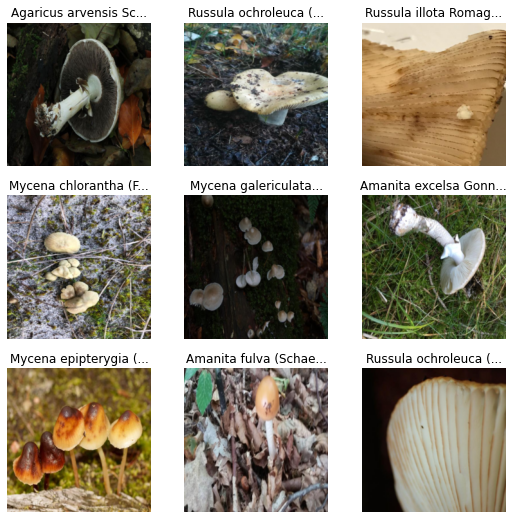

In [3]:
# create fine-tuned network
model = models.get_model(MODEL_ARCH, no_classes, pretrained=False)
training.load_model(model, MODEL_NAME, path=DATA_DIR + 'models')
assert np.all([param.requires_grad for param in model.parameters()])

model_config = model.pretrained_config
batch_size = 128

# create transforms
_, valid_tfms = data.get_transforms(
    size=model_config['input_size'], mean=model_config['image_mean'],
    std=model_config['image_std'])

# create data loaders
validloader = data.get_dataloader(
    valid_df, img_path_col='image_path', label_col='scientificName',
    path=DATA_DIR + TRAIN_SET_DIR, transforms=valid_tfms, labels=classes,
    batch_size=batch_size, shuffle=False, num_workers=4)

validloader.dataset.show_items()

## Create Predictions

In [4]:
# create predictions
pred, targ, _ = training.predict(model, validloader)

In [5]:
# compute scores
scores = training.classification_scores(pred, targ)
pd.Series(scores).round(3) * 100

accuracy    63.1
top_3       81.1
f1_score    51.8
dtype: float64

In [6]:
from src.core import calibration

# tune temperature
temperature = calibration.tune_temperature(model, validloader)

Before temperature - NLL: 1.860
Optimal temperature: 1.605
After temperature - NLL: 1.487
